In [ ]:
! pip install catboost
! pip install optuna
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [3]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import os
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
import random
random.seed(42)
np.random.seed(42)

# 모델 평가 지표 
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

# 제출용 데이터
submit = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/2-2_검증데이터셋.csv', encoding='cp949')

# 1. 데이터 전처리



### 1) 지역명 매핑용 데이터


---


- 결과 df : new_AWS_final

In [ ]:
area_names = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/mapping_data/META_관측지점정보_20220701105117.csv', index_col=0)
AWS = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/mapping_data/AWS.csv', encoding='cp949', index_col=0)
new_AWS = pd.merge(AWS, area_names, left_on='지점번호', right_on='지점', how='left')
new_AWS.drop(['지점', '지점명'], axis=1, inplace=True)
idxs = new_AWS['지점주소'].fillna('non fault')
new_AWS['area'] = [idx.split()[0] for idx in idxs]
def area_words(word):
    if word in ['경상북도', '충청북도', '충청남도', '경상남도', '전라북도', '전라남도']:
        word = list(word)[0] + list(word)[2]
    elif word == '서귀포시':
        word = '제주'
    elif word == 'non':
        word = word
    else:
        word = list(word)[0] + list(word)[1]
    return word 
new_AWS['area'] = [area_words(i) for i in new_AWS['area']]

## 남은 100여개는 직접 매핑한다.
new_AWS_final = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/mapping_data/new_AWS_after.csv', encoding='cp949').drop(['관리관서', '지점주소'], axis=1)
new_AWS_final.drop_duplicates(subset = ['지점번호', '지점명(한글)'],ignore_index=True, inplace=True)
new_AWS_final.drop('지점명(한글)', axis=1, inplace=True)
new_AWS_final.rename(columns={'지점번호' : 'stn_id'}, inplace=True)
new_AWS_final.to_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/mapping_data//new_AWS_final.csv', index=False, encoding='cp949')

new_AWS_final

,stn_id,area
0,90,강원
1,92,강원
2,95,강원
3,96,경북
4,98,경기
...,...,...
687,963,울산
688,966,인천
689,967,인천
690,968,부산


### 2) 백병원 데이터


---


- 결과 df : back

In [ ]:
# data_1 : 2012년 ~ 2015년 일별,성별 백병원 환자 데이터
data_1 = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/hospital_data/back_hospital.csv',index_col=0)
# data_2 : 2016년 validation 데이터
data_2 = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/hospital_data/validation.csv',encoding='cp949')

data_1.columns = data_2.columns
data_2 = data_2.sort_values(['yyyymmdd','area','sex'])
data_2['yyyymmdd'] = data_2['yyyymmdd'].astype(str)
data_2['yyyymmdd'] = data_2['yyyymmdd'].str.replace(pat=r'-', repl=r'', regex=True)
data_2['yyyymmdd'] = data_2['yyyymmdd'].astype('int')

back = pd.concat([data_1,data_2],axis=0)
back.to_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/hospital_data/back.csv',encoding='cp949',index=False)

back

,yyyymmdd,area,sex,frequency
1,20120101,강원,1,3.0
2,20120101,강원,2,3.0
3,20120101,경기,1,4.0
4,20120101,경기,2,5.0
5,20120101,경남,1,2.0
...,...,...,...,...
12441,20161231,제주,2,NaN
12425,20161231,충남,1,NaN
12442,20161231,충남,2,NaN
12426,20161231,충북,1,NaN


### 3) 기상 예보 데이터


---


- 결과 df : back_1

In [ ]:
'''
# 기상 예보 데이터 전처리

- 사용기간: 2012~2016
- '3시간기온','습도','일최고기온','일최저기온','풍속','강수량','적설' 등 5개의 예보대상을 선정
- 당일 9시, 15시, 21시 기상상황을 예보한 데이터
- 결측치는 시계열데이터의 날짜를 기준으로 보간 (interpolate(method='time'))
'''

def extraction(year,target):
  path = '/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/fct_weather_data/'+str(year)
  area_list = os.listdir(path)

  area_dic ={key:list() for key in area_list}
  for area in area_list:
    file_list = os.listdir(path+'/'+area+'/')
    for file in file_list:
      if target in file:
        res = pd.read_csv(path+'/'+area+'/'+file,encoding='cp949')
        area_dic[area].append(res)
  for area in area_list:
    length = len(area_dic[area])
    for i in range(length):

      # 컬럼명 변경
      df=area_dic[area][i] # 약한 복사 (원본 데이터도 바뀜, 이름 편하게 쓰려고)
      df.columns = ['day','hour','forecast','val']

      df.drop_duplicates(inplace=True)

      # 'day' 컬럼에 Start 란 문자열이 들어간 행(월 구분 행) index 추출 
      idxs = df[df['day'].str.contains('Start')].index

      # 'month' 컬럼 추가 
      start_num = 0
      month = 1 
      df['month'] = 0
      for end_num in idxs:
        df.loc[start_num:end_num,'month']= str(month)
        month += 1
        start_num = end_num
      df.loc[start_num:,'month']= month
      del month

      # 'day' 컬럼에 Start 란 문자열이 들어간 행 삭제
      df.drop(idxs,axis=0,inplace=True)

      if(df['hour'].dtypes != 'float'):
        idx = df[df['hour']=='hour'].index
        df.drop(idx,axis=0,inplace=True)


      # 'hour' 컬럼은 현재 float 형(오전 2시는 200, 오후 2시는 1400 이래 표기중)
      # 'hour' 을 100으로 나눠서 최대 10의 자리 정수로 변환
      df['hour'] = df['hour'].astype(float)
      df['hour'] = df['hour']//100



      df['forecast'] = df['forecast'].astype('float')
      # 'hour' 과 'forecast' 의 합이 9, 12, 15, 33, 36, 39 인 행만 추출 살림
      condition1 = ((df['hour']+df['forecast'])!=9)
      condition2 = ((df['hour']+df['forecast'])!=15)
      condition3 = ((df['hour']+df['forecast'])!=21)
      drop_idxs = df.loc[
                        condition1 &condition2 &condition3
                         ].index
      df.drop(drop_idxs,axis=0,inplace =True)
        

      # 'when'컬럼 추가 예보 대상 시점 정보를 담음
      # 예보시점은 불필요
      df['when'] = df['hour']+df['forecast']
      df.drop('hour',axis=1,inplace =True)

      new_columns = ['month','day','when','forecast','val']
      area_dic[area][i] = df[new_columns]
      del new_columns
      # 달,일,예보대상시점,몇시간전 예보인지 순으로 재정렬 & 인덱스 재설정
      df.sort_values(['month','day','when','forecast'],inplace=True)
      df.reset_index(drop=True, inplace=True)


  # regional_integration_df 딕셔너리 안에 지역별 outer join 된 dataframe이 들어감
  # 딕셔너리 키 값은 지역명
  regional_integration_df = {key:0 for key in area_list}


  for area in area_list:
    length = len(area_dic[area])
    if length == 0:
      continue
    res = area_dic[area][0].copy()
    for i in range(1,length):
      res = pd.merge(res,area_dic[area][i].copy(),how='outer',on=['month','day','when','forecast'])
    regional_integration_df[area]=res
  del area_dic

  # 관측소마다 내놓은 예보 값의 mean과 max를 구함
  for area in area_list: 
    regional_integration_df[area].iloc[:,4:] = regional_integration_df[area].iloc[:,4:].astype('float')
    val_mean = regional_integration_df[area].iloc[:,4:].mean(axis='columns')
    regional_integration_df[area][f'{target}_mean'] = val_mean

    # 'yyyymmdd'컬럼 생성 (datetime 형식) 
    regional_integration_df[area]['year'] = year
    regional_integration_df[area]['month'] = regional_integration_df[area]['month'].astype(int) 
    regional_integration_df[area]['day'] = regional_integration_df[area]['day'].astype(int)
    regional_integration_df[area]['yyyymmdd'] = regional_integration_df[area]['year']*10000 + regional_integration_df[area]['month']*100+regional_integration_df[area]['day'] 
    regional_integration_df[area].drop(['month','day','year'],axis = 1, inplace=True)
    regional_integration_df[area]['yyyymmdd'] = regional_integration_df[area]['yyyymmdd'].astype(str)
      
    # 사용할 컬럼만 추림 (['yyyymmdd''when','forecast','val_mean','val_max'])
    regional_integration_df[area] = regional_integration_df[area][['yyyymmdd','when','forecast',f'{target}_mean']]

    regional_integration_df[area]['yyyymmdd'] = pd.to_datetime(regional_integration_df[area]['yyyymmdd'], dayfirst=True, errors='coerce')
    regional_integration_df[area] = regional_integration_df[area][pd.notnull(regional_integration_df[area]['yyyymmdd'])]

    # 병병원데이터에 붙힐 수 있도록 reshape
    regional_integration_df[area]['yyyymmdd'] = pd.to_datetime(regional_integration_df[area]['yyyymmdd'])
    regional_integration_df[area]  = regional_integration_df[area].groupby(['yyyymmdd','when'],as_index=False)[f'{target}_mean'].mean()
    regional_integration_df[area] = regional_integration_df[area].pivot(index='yyyymmdd',columns=['when'],values=[f'{target}_mean'])
    regional_integration_df[area].columns = [col[0]+'_'+str(int(col[1])) for col in regional_integration_df[area].columns]

    # 지역명도 column에 추가
    regional_integration_df[area]['area'] = area


  return regional_integration_df

area_list = ['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '세종', '울산', '인천', '전남', '전북', '제주', '충남', '충북']


subject = ['3시간기온','습도','일최고기온','일최저기온','풍속','강수량','적설']

fct_final = []

for sub in subject:
  
  res_sep_year = []
  res_df = pd.DataFrame()

  for year in range(2012,2016+1):
    # extraction() 에 연도와 목표 data의 이름을 넣으면 지역별로 정리된 dictionary 반환
    # res_sep_year 는 시간별로 정리된 dictionay list (인덱스 0 은 2012 , 인덱스 5는 2016)
    
    res_sep_year.append(extraction(year,sub))
    
    for area in area_list:

      #시계열로 데이터 보간
      res_sep_year[year-2012][area].iloc[:,0:3] = res_sep_year[year-2012][area].iloc[:,0:3].interpolate(method='time')
      res_sep_year[year-2012][area].iloc[:,0:3] = res_sep_year[year-2012][area].iloc[:,0:3].interpolate(method='time',limit_direction='backward')


      # 지역별로 나눠진 df 하나로 합치기 (pre_merge)
      res_df = pd.concat([res_df,res_sep_year[year-2012][area]],axis = 0)

  # 시계열 인덱스로부터 'yyyymmdd' 칼럼 추출
  res_df['yyyymmdd'] = res_df.index
  # 'yyyymmdd'를 백병원 데이터의 'yyyymmdd' 형식과 일치시킴
  res_df['yyyymmdd'] = res_df['yyyymmdd'].astype(str)
  res_df['yyyymmdd'] = res_df['yyyymmdd'].str.replace(pat=r'-', repl=r'', regex=True)
  res_df['yyyymmdd'] = res_df['yyyymmdd'].astype(int)
  # res 인덱스를 일반적인 색인으로 변환 (0,1,2,3,...) 
  res_df.index = [i for i in range(len(res_df))]  

  fct_final.append(res_df)

# 주제별로 나눠진 df 하나로 합치기 (pre_merge)
pre_merge = pd.merge(fct_final[0], fct_final[1], how='outer', on =['yyyymmdd','area'])
for i in range(2,7):
  pre_merge = pd.merge(pre_merge, fct_final[i], how='outer', on =['yyyymmdd','area'])

# 백병원데이터
back_1 = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/hospital_data/back.csv',encoding='cp949')

def area_words(word):
    if word == '전북':
      word = '전북'
    elif word == '제주':
      word = '제주'
    elif word == '충남':
      word = '충남'
    elif word == '충북':
      word = '충북'
    elif word == '강원':
      word = '강원'
    elif word == '경기':
      word = '경기'
    elif word == '경남':
      word = '경남'
    elif word == '경북':
      word = '경북'
    elif word == '광주':
      word = '광주'
    elif word == '대구':
      word = '대구'
    elif word == '대전':
      word = '대전'
    elif word == '부산':
      word = '부산'
    elif word == '서울':
      word = '서울'
    elif word == '세종':
      word = '세종'
    elif word == '울산':
      word = '울산'
    elif word == '인천':
      word = '인천'
    elif word == '전남':
      word = '전남'
    return word

pre_merge['area'] = [area_words(i) for i in pre_merge['area']]
back_1 = pd.merge(back_1, pre_merge, how='outer', on =['yyyymmdd','area'])

# 지역, 시간 별로 정렬 후 시간을 기준으로 결측치 보정
back_cpy = back_1.sort_values(['area','yyyymmdd']).copy()
back_cpy['yyyymmdd'] = pd.to_datetime(back_cpy['yyyymmdd'],format='%Y%m%d')
back_cpy.set_index('yyyymmdd',inplace=True)
back_cpy.iloc[:,3:] = back_cpy.iloc[:,3:].interpolate(method='time')

back_cpy['yyyymmdd'] = back_cpy.index
back_cpy['sex'].unique()
back_cpy.index = [i for i in range(len(back_cpy))] 

back_cpy.sort_values(['yyyymmdd','area'],inplace=True)

back_cpy['yyyymmdd'] = back_cpy['yyyymmdd'].astype(str)
back_cpy['yyyymmdd'] = back_cpy['yyyymmdd'].str.replace(pat=r'-', repl=r'', regex=True)
back_cpy['yyyymmdd'] = back_cpy['yyyymmdd'].astype('int')

back_cpy = back_cpy[back_1.columns]
back_cpy.reset_index(drop=True,inplace=True)

back_1 = back_cpy

back_1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: FutureWarning: Passing 'suffixes' which cause duplicate columns {'val_x'} in the result is deprecated and will raise a MergeError in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: FutureWarning: Passing 'suffixes' which cause duplicate columns {'val_x'} in the result is deprecated and will raise a MergeError in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,yyyymmdd,area,sex,frequency,3시간기온_mean_9,3시간기온_mean_15,3시간기온_mean_21,습도_mean_9,습도_mean_15,습도_mean_21,...,일최저기온_mean_21,풍속_mean_9,풍속_mean_15,풍속_mean_21,강수량_mean_9,강수량_mean_15,강수량_mean_21,적설_mean_9,적설_mean_15,적설_mean_21
0,20120101,강원,1,3.0,-1.657143,-5.650000,-8.032143,50.642857,78.982143,83.250000,...,-9.000000,286.714286,288.285714,163.976190,2.5,2.142857,0.267857,2.5,1.875,0.267857
1,20120101,강원,2,3.0,-1.657143,-5.650000,-8.032143,50.642857,78.982143,83.250000,...,-9.000000,286.714286,288.285714,163.976190,2.5,2.142857,0.267857,2.5,1.875,0.267857
2,20120101,경기,1,4.0,-2.520000,-6.440000,-9.756667,44.400000,64.100000,79.533333,...,-9.530000,319.600000,318.800000,289.666667,0.0,0.000000,0.000000,0.0,0.000,0.000000
3,20120101,경기,2,5.0,-2.520000,-6.440000,-9.756667,44.400000,64.100000,79.533333,...,-9.530000,319.600000,318.800000,289.666667,0.0,0.000000,0.000000,0.0,0.000,0.000000
4,20120101,경남,1,2.0,2.492857,-2.101786,-4.680952,40.071429,59.803571,68.476190,...,-4.339286,313.571429,312.785714,284.380952,0.0,0.000000,0.000000,0.0,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62113,20161231,제주,2,NaN,8.600000,6.275000,5.650000,56.500000,64.375000,66.333333,...,6.883333,4.850000,2.847917,2.027778,3.0,5.000000,1.000000,5.0,1.000,1.000000
62114,20161231,충남,1,NaN,3.216667,-0.970833,-1.831111,76.000000,88.750000,88.155556,...,-0.035000,1.266667,0.662500,0.950000,3.0,5.000000,1.000000,5.0,1.000,1.000000
62115,20161231,충남,2,NaN,3.216667,-0.970833,-1.831111,76.000000,88.750000,88.155556,...,-0.035000,1.266667,0.662500,0.950000,3.0,5.000000,1.000000,5.0,1.000,1.000000
62116,20161231,충북,1,NaN,1.516667,-0.616667,-2.432222,79.250000,82.300000,86.972222,...,-0.866667,1.800000,0.900000,0.816667,3.0,5.000000,1.000000,5.0,1.000,1.000000


### 4) 연도별, 지역별, 성별 인구데이터


---


- 결과 df : back_2

In [ ]:
'''
# 인구 데이터

- 사용기간: 2012~2016
- KOSIS 제공한 행정구역별, 성별인구 수 데이터  
- 2012 년 세종시의 경우, 2012년 7월에 출범한 특별자치시이기 때문에, 그 이전에 분류된 데이터가 없다. 시간 순으로 정렬한 후, 밑에서 위로 선형 비례하도록 결측치를 보간
'''

path = '/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/'

# [백병원 데이터] 불러오기
back_2 =  pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/hospital_data/back.csv',encoding='cp949')

# [인구 데이터] 불러오기
pap = [0] * 5
for i in range(len(pap)):
  pap[i] = pd.read_csv(path+'papulation_data/'+str(i+2012)+'.csv', encoding ='cp949')

## [인구 데이터] 컬럼명 수정
new_columns = ['area',"Jan","Jan_남","Jan_여",
               "Feb","Feb_남","Feb_여","Mar","Mar_남","Mar_여",
               "Apr","Apr_남","Apr_여","May","May_남","May_여",
               "Jun","Jun_남","Jun_여","Jul","Jul_남","Jul_여",
               "Aug","Aug_남","Aug_여","Sep","Sep_남","Sep_여",
               "Oct","Oct_남","Oct_여","Nov","Nov_남","Nov_여",
               "Dec","Dec_남","Dec_여"]

## [인구 데이터] 불필요한 컬럼 삭제
for i in range(len(pap)):
  pap[i].columns = new_columns
  pap[i].drop(0,axis =0,inplace=True)
  pap[i].drop(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],axis =1,inplace=True)
  pap[i].reset_index(drop=True,inplace=True)

## [인구 데이터] '년도별' -> '월별' 로 세분화 및 재구성
pretreatment = pd.DataFrame()

for i in range(5):
  year = 2012+i
  for row in range(18):
     for j in range(1,25, 2):
      month = int((j+1)/2)
      area = pap[i].iloc[row,0]
      yymm = ''
      if month < 10:
        yymm = str(year) + '0' + str(month)
      else:
        yymm = str(year) + str(month)
      new_data = pd.DataFrame({
                'area':[area,area],
                'sex':[1,2],
                'yymmdd':[yymm,yymm],
                'tot_person':list(pap[i].iloc[row,j:j+2])})
      pretreatment = pd.concat([pretreatment,new_data])

## [인구 데이터] '전국' 단위의 측정값은 제거
pretreatment.reset_index(drop=True,inplace=True)
drop_row = pretreatment[pretreatment['area'] == '전국'].index
pretreatment.drop(drop_row ,axis=0,inplace=True)
pretreatment.reset_index(drop=True,inplace=True)

## [인구 데이터] 백병원 데이터 기준으로 지역명 통일
old_name = pretreatment.area.unique()
new_name = back_2['area'].unique()

for i in range(len(old_name)):
  pretreatment.loc[pretreatment['area'] == old_name[i], 'area'] = new_name[i]

## [인구 데이터] '월별' -> '일별' 데이터로 세분화 및 재구성
pretreatment_2 = pd.DataFrame()

def dd_insert(tot_date , i):
  global pretreatment_2
  for j in range(1,tot_date+1):
      date = ''
      if j<10:
        date = '0'+str(j)
      else:
        date = str(j)
      new_data_frame = pd.DataFrame({
          "area":list(pretreatment.iloc[i:i+2,0]),
          "sex":list(pretreatment.iloc[i:i+2,1]),
          "yymmdd":[str(pretreatment.iloc[i,2])+date,str(pretreatment.iloc[i,2])+date],
          "tot_person":list(pretreatment.iloc[i:i+2,3]),
      })
      pretreatment_2 = pd.concat([pretreatment_2,new_data_frame])


for i in range(0,len(pretreatment),2):
  month = int(pretreatment.iloc[i,2]) % 100
  if(month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month == 12):
    dd_insert(31,i)
  elif (month == 4 or month == 6 or month == 9 or month == 11):
    dd_insert(30,i)
  else:
    year = int(int(pretreatment.iloc[i,2])/100)
    if(year == 2012 or year == 2016):
      dd_insert(29,i)
    else:
      dd_insert(28,i)

## [인구데이터] 백병원 데이터 기준으로 컬럼명, 타입 통일
pretreatment_2.columns = ['area', 'sex', 'yyyymmdd', 'tot_person']
pretreatment_2= pretreatment_2.astype({'yyyymmdd':'int64'})

## [인구데이터],[백병원 데이터] outer join
back_merge_papulation = pd.merge(back_2,pretreatment_2, on=['yyyymmdd','area','sex'],how='outer')

del pretreatment_2
del pretreatment

## back_merge_papulation 세종시 결측치 보간
def sejong_nan(dfile, sex):
  a = dfile[(dfile['area']=='세종') & (dfile['sex']==sex)]
  idx = a['tot_person'].interpolate(limit_direction='backward').index
  dfile.loc[idx, 'tot_person'] = a['tot_person'].interpolate(limit_direction='backward').values
  return dfile
back_merge_papulation = sejong_nan(back_merge_papulation,1)
back_merge_papulation = sejong_nan(back_merge_papulation,2)

# [위험연령 인구수 데이터] 불러오기
## [위험연령 인구수 데이터] - 남성
def risk_age_primary_processing_man(target):
  data_set = [0]*4
  
  data_set[0] = pd.read_csv(path+'risk_age_range/'+str(target)+'01_'+str(target)+'03_연령별인구현황_월간.csv',encoding='cp949')
  data_set[1] = pd.read_csv(path+'risk_age_range/'+str(target)+'04_'+str(target)+'06_연령별인구현황_월간.csv',encoding='cp949')
  data_set[2] = pd.read_csv(path+'risk_age_range/'+str(target)+'07_'+str(target)+'09_연령별인구현황_월간.csv',encoding='cp949')
  data_set[3] = pd.read_csv(path+'risk_age_range/'+str(target)+'10_'+str(target)+'12_연령별인구현황_월간.csv',encoding='cp949')

  data_set_cpy = [0]*4

  for i in range(4):
    data_set_cpy[i]=data_set[i].copy()

  important_col = []
  for i in range(113):
    if(data_set[0].columns[i] == '행정구역' or data_set[0].columns[i] ==str(target)+'년01월_남_연령구간인구수'or data_set[0].columns[i] ==str(target)+'년02월_남_연령구간인구수' or data_set[0].columns[i] ==str(target)+'년03월_남_연령구간인구수'):
      important_col.append(i)
  col_name = []

  for i in range(127):
    if(i in important_col):
      col_name.append('important_'+str(i))
    else:
      col_name.append(str(i))

  for i in range(len(data_set)):
    data_set[i].columns = col_name
  
  drop_col = data_set[0].columns

  for i in range(4):
    for j in range(127):
      if(str(j) in drop_col):
        data_set[i].drop(str(j),axis=1,inplace=True)

  data_set[0].columns = ['area','man_01','man_02','man_03']
  data_set[1].columns = ['area','man_04','man_05','man_06']
  data_set[2].columns = ['area','man_07','man_08','man_09']
  data_set[3].columns = ['area','man_10','man_11','man_12']

  target_df = pd.merge(data_set[0],data_set[1], on=['area'],how='outer')
  target_df = pd.merge(target_df,data_set[2], on=['area'],how='outer')
  target_df = pd.merge(target_df,data_set[3], on=['area'],how='outer')

  for j in range(len(target_df)):
    target_df.iloc[j,:] = target_df.iloc[j,:].str.replace('[,]','')
  return target_df

## [위험연령 인구수 데이터] - 여성
def risk_age_primary_processing_woman(target):
  data_set = [0]*4

  data_set[0] = pd.read_csv(path+'risk_age_range/'+str(target)+'01_'+str(target)+'03_연령별인구현황_월간.csv',encoding='cp949')
  data_set[1] = pd.read_csv(path+'risk_age_range/'+str(target)+'04_'+str(target)+'06_연령별인구현황_월간.csv',encoding='cp949')
  data_set[2] = pd.read_csv(path+'risk_age_range/'+str(target)+'07_'+str(target)+'09_연령별인구현황_월간.csv',encoding='cp949')
  data_set[3] = pd.read_csv(path+'risk_age_range/'+str(target)+'10_'+str(target)+'12_연령별인구현황_월간.csv',encoding='cp949')

  important_col = []
  for i in range(127):
    if(data_set[0].columns[i] == '행정구역' 
      or data_set[0].columns[i] ==str(target)+'년01월_여_연령구간인구수'
      or data_set[0].columns[i] ==str(target)+'년01월_여_45~49세'
      or data_set[0].columns[i] ==str(target)+'년01월_여_50~54세'
      or data_set[0].columns[i] ==str(target)+'년02월_여_연령구간인구수'
      or data_set[0].columns[i] ==str(target)+'년02월_여_45~49세'
      or data_set[0].columns[i] ==str(target)+'년02월_여_50~54세'
      or data_set[0].columns[i] ==str(target)+'년03월_여_연령구간인구수'
      or data_set[0].columns[i] ==str(target)+'년03월_여_45~49세'
      or data_set[0].columns[i] ==str(target)+'년03월_여_50~54세'):
      important_col.append(i)

  col_name = []

  for i in range(127):
    if(i in important_col):
      col_name.append('important_'+str(i))
    else:
      col_name.append(str(i))
  for i in range(len(data_set)):
    data_set[i].columns = col_name
  
  drop_col = data_set[0].columns


  for i in range(4):
    for j in range(127):
      if(str(j) in drop_col):
        data_set[i].drop(str(j),axis=1,inplace=True)
  for i in range(4):
    for j in range(len(data_set[i])):
      data_set[i].iloc[j,1:4] = data_set[i].iloc[j,1:4].str.replace('[,]','')
      data_set[i].iloc[j,4:7] = data_set[i].iloc[j,4:7].str.replace('[,]','')
      data_set[i].iloc[j,7:10] = data_set[i].iloc[j,7:10].str.replace('[,]','')
      data_set[i].iloc[j,1:4] = pd.to_numeric(data_set[i].iloc[j,1:4],errors='coerce')
      data_set[i].iloc[j,4:7] = pd.to_numeric(data_set[i].iloc[j,4:7],errors='coerce')
      data_set[i].iloc[j,7:10] = pd.to_numeric(data_set[i].iloc[j,7:10],errors='coerce')
  
  data_set[0]['area'] = data_set[0]['important_0']
  data_set[1]['area'] = data_set[1]['important_0']
  data_set[2]['area'] = data_set[2]['important_0']
  data_set[3]['area'] = data_set[3]['important_0']

  data_set[0]['woman_01'] = data_set[0]['important_30'] -data_set[0]['important_31'] - data_set[0]['important_32']
  data_set[0]['woman_02'] = data_set[0]['important_72'] - data_set[0]['important_73'] - data_set[0]['important_74']
  data_set[0]['woman_03'] = data_set[0]['important_114'] - data_set[0]['important_115'] - data_set[0]['important_116']
  data_set[1]['woman_04'] = data_set[1]['important_30'] -data_set[1]['important_31'] - data_set[1]['important_32']
  data_set[1]['woman_05'] = data_set[1]['important_72'] - data_set[1]['important_73'] - data_set[1]['important_74']
  data_set[1]['woman_06'] = data_set[1]['important_114'] - data_set[1]['important_115'] - data_set[1]['important_116']
  data_set[2]['woman_07'] = data_set[2]['important_30'] -data_set[2]['important_31'] - data_set[2]['important_32']
  data_set[2]['woman_08'] = data_set[2]['important_72'] - data_set[2]['important_73'] - data_set[2]['important_74']
  data_set[2]['woman_09'] = data_set[2]['important_114'] - data_set[2]['important_115'] - data_set[2]['important_116']
  data_set[3]['woman_10'] = data_set[3]['important_30'] -data_set[3]['important_31'] - data_set[3]['important_32']
  data_set[3]['woman_11'] = data_set[3]['important_72'] - data_set[3]['important_73'] - data_set[3]['important_74']
  data_set[3]['woman_12'] = data_set[3]['important_114'] - data_set[3]['important_115'] - data_set[3]['important_116']

  for i in range(4):
    data_set[i].drop(['important_0','important_30','important_31','important_32','important_72','important_73','important_74','important_114','important_115','important_116'],axis=1,inplace=True)
  
  target_df = pd.merge(data_set[0],data_set[1], on=['area'],how='outer')
  target_df = pd.merge(target_df,data_set[2], on=['area'],how='outer')
  target_df = pd.merge(target_df,data_set[3], on=['area'],how='outer')

  return target_df

risk_m = [0] * 5
risk_w = [0] * 5

for i in range(5):
  year = 2012+i
  risk_m[i] = risk_age_primary_processing_man(year)
  risk_w[i] = risk_age_primary_processing_woman(year)

def drop_row(df, idx):
  return df.drop(df.index[idx])

for i in range(len(risk_m)):
  risk_m[i] = drop_row(risk_m[i],0)
  risk_w[i] = drop_row(risk_w[i],0)

new_names = back_2['area'].unique()

for i in range(len(risk_m)):
  
  risk_m[i].sort_values(by='area',axis=0,inplace=True)
  old_names = risk_m[i]['area'].unique()
  for j in range(len(old_names)):
    risk_m[i].loc[risk_m[i]['area'] == old_names[j], 'area'] = new_names[j]
  del old_names
  risk_m[i].reset_index(drop=True,inplace=True)

  risk_w[i].sort_values(by='area',axis=0,inplace=True)
  old_names = risk_w[i]['area'].unique()
  for j in range(len(old_names)):
    risk_w[i].loc[risk_w[i]['area'] == old_names[j], 'area'] = new_names[j]
  del old_names
  risk_w[i].reset_index(drop=True,inplace=True)

pretreatment1_m = pd.DataFrame()

for i in range(len(risk_m)):
  year = str(i+2012)
  for row in range(len(new_names)):
    for month in range(1,12+1):
      yyyymm = year
      if(month < 10):
        yyyymm += '0' + str(month)
      else:
        yyyymm += str(month)
      new_data_frame = pd.DataFrame({
          "area": risk_m[i].iloc[row,0],
          "yyyymm": yyyymm ,
          "num_risk_age":risk_m[i].iloc[row,month:month+1]
     })
      pretreatment1_m = pd.concat([pretreatment1_m, new_data_frame])

pretreatment1_w = pd.DataFrame()

for i in range(len(risk_w)):
  year = str(i+2012)
  for row in range(len(new_names)):
    for month in range(1,12+1):
      yyyymm = year
      if(month < 10):
        yyyymm += '0' + str(month)
      else:
        yyyymm += str(month)
      new_data_frame = pd.DataFrame({
          "area": risk_w[i].iloc[row,0],
          "yyyymm": yyyymm ,
          "num_risk_age":risk_w[i].iloc[row,month:month+1]
     })
      pretreatment1_w = pd.concat([pretreatment1_w, new_data_frame])

pretreatment1_w.reset_index(drop=True,inplace=True)
pretreatment1_m.reset_index(drop=True,inplace=True)

pretreatment1_m['sex'] =1
pretreatment1_w['sex'] =2

pretreatment1 = pd.concat([pretreatment1_m,pretreatment1_w])
pretreatment1.sort_values(by=['area','yyyymm'],inplace=True)
pretreatment1['num_risk_age'] = pd.to_numeric(pretreatment1['num_risk_age'],errors='coerce')
pretreatment1['yyyymm'] = pd.to_numeric(pretreatment1['yyyymm'],errors='coerce')


pretreatment_2 = pd.DataFrame()

def dd_insert(tot_date , i):
  global pretreatment_2
  for j in range(1,tot_date+1):
      date = ''
      if j<10:
        date = '0'+str(j)
      else:
        date = str(j)
      new_data_frame = pd.DataFrame({
          "area":list(pretreatment1.iloc[i:i+2,0]),
          "yymmdd":[str(pretreatment1.iloc[i,1])+date,str(pretreatment1.iloc[i,1])+date],
          "sex":list(pretreatment1.iloc[i:i+2,3]),
          "num_risk_age":list(pretreatment1.iloc[i:i+2,2]),
      })
      pretreatment_2 = pd.concat([pretreatment_2,new_data_frame])
  

for i in range(0,len(pretreatment1),2):
  month = int(pretreatment1.iloc[i,1]) % 100
  if(month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month == 12):
    dd_insert(31,i)
  elif (month == 4 or month == 6 or month == 9 or month == 11):
    dd_insert(30,i)
  else:
    year = int(int(pretreatment1.iloc[i,1])/100)
    if(year == 2012 or year == 2016):
      dd_insert(29,i)
    else:
      dd_insert(28,i)
pretreatment_2.reset_index(drop=True,inplace=True)
pretreatment_2.columns =['area', 'yyyymmdd', 'sex', 'num_risk_age']

pretreatment_2= pretreatment_2.astype({'yyyymmdd':'int64'})
back_2 = pd.merge(back_merge_papulation,pretreatment_2, on=['yyyymmdd','area','sex'],how='outer')

del pretreatment_2

back_2= sejong_nan(back_2,1)
back_2= sejong_nan(back_2,2)

back_2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:168: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:213: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:214: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:215: FutureWarning: The default value of regex will change from True to False in a future version.


,yyyymmdd,area,sex,frequency,tot_person,num_risk_age
0,20120101,강원,1,3.0,772718,322636.0
1,20120101,강원,2,3.0,762617,229447.0
2,20120101,경기,1,4.0,6020446,2054584.0
3,20120101,경기,2,5.0,5928150,1182747.0
4,20120101,경남,1,2.0,1665308,622268.0
...,...,...,...,...,...,...
62113,20161231,제주,2,NaN,319052,94654.0
62114,20161231,충남,1,NaN,1064765,471322.0
62115,20161231,충남,2,NaN,1031962,348117.0
62116,20161231,충북,1,NaN,803240,358361.0


### 5) 생활지수(예보) 데이터


---


- 결과 df : back_3

In [ ]:
# 생활지수 예보 데이터 전처리
'''
- 사용기간: 2012~2016
- A03 (체감온도), A04(동상가능지수), A05(열지수), A06(불쾌지수) 등 4개의 코드 사용
- 발표시각은 오전 6시 기준
- 발표시각을 기준으로 3시간 뒤 (t1), 6시간 뒤 (t2), 9시간 뒤 (t3) 의 예보데이터 사용
- 2013년과 2014년 사이 방재기상관측지점 의 stn-id 와 동내예보구역의 stn-id로 매핑된 데이터가 동시에 존재했기 때문에,
    각각 따로 추출하여 둘 data의 시점이 일치하는 경우, 평균값으로 대체
- 방재기상관측지점(aws) 의 stn-id를 기준으로 매핑된 데이터의 경우,
기상자료개방포털(https://data.kma.go.kr/tmeta/stn/selectStnList.do?)의 관측지점정보를 이용하여 읍면동 단위 행정구역 이름을 시도 단위로 대체하였다.
-  지역명, 발표시간 기준으로 그룹화하여 평균값을 구함
'''

  # aws 지역명 매핑용 데이터
new_AWS = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/mapping_data/new_AWS_final.csv',encoding='cp949')

  # t4~t8 컬럼 삭제
def drop_col_t4_t8(df):
  drop_col = ['t4',	't5',	't6',	't7',	't8']
  if drop_col[0] in df.columns:
    df.drop(drop_col, axis=1, inplace=True)
  return df

  # area 매핑
def mapping_aws(df):
    df = pd.merge(df, new_AWS, on='stn_id', how='left')
    df.drop(['stn_id','지점명(한글)'], axis=1, inplace=True)
    return df

  # 발표시각(tm_fc) 관측시간 오전 6시만 살림(관측 년,월,일은 살림)
def remove_hour(df):
  df = df.loc[df['tm_fc'].str.contains('06:00:00')]
  df['tm_fc'] = df.tm_fc.str.split().str[0]
  return df

  # 지역명, 발표시간 기준으로 그룹화(최고값, 평균값)
def groupby_tm_area(df,start,end,group_key):
  df.fillna({'t1':0,'t2':0,'t3':0},inplace=True)
  cols = df.columns[start:end].tolist()
  df = df.groupby(group_key)[cols].agg('mean').reset_index()
  df.columns = list(map(''.join, df.columns.values))
  df = df.rename(columns={'tm_fc_' : 'tm_fc','area_' : 'area'})
  return df


  # 예측 column 옆에 코드 각인 ( ex) A03_t2_max )
def engrave_code(df, cod):
  change_names = ['t1','t2','t3']
  for name in change_names:
    df.rename(columns={str(name):str(cod)+'_'+str(name)},inplace=True)
  return df

  # 발표시각(tm_fc) 형변환
def cast_tm_fc(df):
  df.tm_fc =pd.to_datetime(df.tm_fc)
  df.tm_fc = df.tm_fc.dt.strftime('%Y%m%d')
  return df

  # 동네예보구역 매핑 데이터 지역명 변경
def area_words(word):
    if (str(type(word))!="<class 'str'>"):
      return word

    if word in ['경상북도', '충청북도', '충청남도', '경상남도', '전라북도', '전라남도']:
        word = list(word)[0] + list(word)[2]
    elif word == '이어도':
        word = '제주'
    else:
        word = list(word)[0] + list(word)[1]
    return word 


# aws 매핑 데이터 불러오기 및 전처리
path = '/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/fct_life/mapping_aws/'
file_list = os.listdir(path)

file_name_comm = 'fct_life_'
year_for_A03 = year_for_A04 = year_for_A05 = year_for_A06 = 0

data_aws_A03 = []
data_aws_A04 = []
data_aws_A05 = []
data_aws_A06 = []

res_aws_data = [pd.DataFrame() for _ in range(4)]

for i in file_list:
  if 'A03' in i:
    target = 'A03'
    res = pd.read_csv(path + file_name_comm+str(2012+year_for_A03)+'_'+target+'_aws.csv',encoding='cp949',index_col=0)
    data_aws_A03.append(res)
    res_aws_data[0] = pd.concat(data_aws_A03, axis=0, ignore_index = True)
    year_for_A03+=1
  
  elif 'A04' in i:
    target = 'A04'
    res = pd.read_csv(path + file_name_comm+str(2012+year_for_A04)+'_'+target+'_aws.csv',encoding='cp949',index_col=0)
    data_aws_A04.append(res)
    res_aws_data[1] = pd.concat(data_aws_A04, axis=0, ignore_index = True)
    year_for_A04+=1

  elif 'A05' in i:
    target = 'A05'
    res = pd.read_csv(path + file_name_comm+str(2012+year_for_A05)+'_'+target+'_aws.csv',encoding='cp949',index_col=0)
    data_aws_A05.append(res)
    res_aws_data[2] = pd.concat(data_aws_A05, axis=0, ignore_index = True)
    year_for_A05+=1

  elif 'A06' in i:
    target = 'A06'
    res = pd.read_csv(path + file_name_comm+str(2012+year_for_A06)+'_'+target+'_aws.csv',encoding='cp949',index_col=0)
    data_aws_A06.append(res)
    res_aws_data[3] = pd.concat(data_aws_A06, axis=0, ignore_index = True)
    year_for_A06+=1

for i in range(len(res_aws_data)):
  res_aws_data[i] =drop_col_t4_t8(res_aws_data[i].copy())
  res_aws_data[i] = mapping_aws(res_aws_data[i].copy())
  res_aws_data[i] = remove_hour(res_aws_data[i].copy())
  res_aws_data[i] = groupby_tm_area(res_aws_data[i].copy(),2,5,['tm_fc','area'])
  code = 'A0'+str(i+3)
  res_aws_data[i] = engrave_code(res_aws_data[i].copy(),code)
  res_aws_data[i] = cast_tm_fc(res_aws_data[i].copy())



# 동네예보구역 매핑 데이터 전처리
def fct_preprocess(df,code):
  df=drop_col_t4_t8(df)
  df=remove_hour(df.copy())
  df = df.rename(columns={'1단계' : 'area'})
  df['area'] = [area_words(i) for i in df['area']]
  df.dropna(subset=['area'])
  df=groupby_tm_area(df,3,6,['tm_fc','area'])
  df=engrave_code(df, code)
  df = cast_tm_fc(df)
  
  return df

path = '/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/fct_life/mapping_fct/'

res_fct_data = [pd.DataFrame() for _ in range(4)]
data_list = []

# A03
fct_A03_2012 = pd.read_csv(path+'fct_life_2012_A03_fct.csv',encoding='cp949',index_col=0)
fct_A03_2012 = fct_preprocess(fct_A03_2012,'A03')
data_list.append(fct_A03_2012)
fct_A03_2013 = pd.read_csv(path+'fct_life_2013_A03_fct.csv',encoding='cp949',index_col=0)
fct_A03_2013 =fct_preprocess(fct_A03_2013,'A03')
data_list.append(fct_A03_2013)
fct_A03_2014 = pd.read_csv(path+'fct_life_2014_A03_fct.csv',encoding='cp949',index_col=0)
fct_A03_2014 =fct_preprocess(fct_A03_2014,'A03')
data_list.append(fct_A03_2014)
fct_A03_2015 = pd.read_csv(path+'fct_life_2015_A03_fct.csv',encoding='cp949',index_col=0)
fct_A03_2015 = fct_preprocess(fct_A03_2015,'A03')
data_list.append(fct_A03_2015)
fct_A03_2016 = pd.read_csv(path+'fct_life_2016_A03_fct.csv',encoding='cp949',index_col=0)
fct_A03_2016 = fct_preprocess(fct_A03_2016,'A03')
data_list.append(fct_A03_2016)
res_fct_data[0] = pd.concat(data_list, axis=0, ignore_index = True)
del fct_A03_2012,fct_A03_2013,fct_A03_2014,fct_A03_2015,fct_A03_2016

data_list = []

#A04
fct_A04_2012 = pd.read_csv(path+'fct_life_2012_A04_fct.csv',encoding='cp949',index_col=0)
fct_A04_2012 = fct_preprocess(fct_A04_2012,'A04')
data_list.append(fct_A04_2012)
fct_A04_2013 = pd.read_csv(path+'fct_life_2013_A04_fct.csv',encoding='cp949',index_col=0)
fct_A04_2013 = fct_preprocess(fct_A04_2013,'A04')
data_list.append(fct_A04_2013)
fct_A04_2014 = pd.read_csv(path+'fct_life_2014_A04_fct.csv',encoding='cp949',index_col=0)
fct_A04_2014 = fct_preprocess(fct_A04_2014,'A04')
data_list.append(fct_A04_2014)
fct_A04_2015 = pd.read_csv(path+'fct_life_2015_A04_fct.csv',encoding='cp949',index_col=0)
fct_A04_2015 = fct_preprocess(fct_A04_2015,'A04')
data_list.append(fct_A04_2015)
fct_A04_2016 = pd.read_csv(path+'fct_life_2016_A04_fct.csv',encoding='cp949',index_col=0)
fct_A04_2016 = fct_preprocess(fct_A04_2016,'A04')
data_list.append(fct_A04_2016)
res_fct_data[1] = pd.concat(data_list, axis=0, ignore_index = True)
del fct_A04_2012,fct_A04_2013,fct_A04_2014,fct_A04_2015,fct_A04_2016

data_list = []

#A05
fct_A05_2012 = pd.read_csv(path+'fct_life_2012_A05_fct.csv',encoding='cp949',index_col=0)
fct_A05_2012 = fct_preprocess(fct_A05_2012,'A05')
data_list.append(fct_A05_2012)
fct_A05_2013 = pd.read_csv(path+'fct_life_2013_A05_fct.csv',encoding='cp949',index_col=0)
fct_A05_2013 = fct_preprocess(fct_A05_2013,'A05')
data_list.append(fct_A05_2013)
fct_A05_2014 = pd.read_csv(path+'fct_life_2014_A05_fct.csv',encoding='cp949',index_col=0)
fct_A05_2014 = fct_preprocess(fct_A05_2014,'A05')
data_list.append(fct_A05_2014)
fct_A05_2015 = pd.read_csv(path+'fct_life_2015_A05_fct.csv',encoding='cp949',index_col=0)
fct_A05_2015 = fct_preprocess(fct_A05_2015,'A05')
data_list.append(fct_A05_2015)
fct_A05_2016 = pd.read_csv(path+'fct_life_2016_A05_fct.csv',encoding='cp949',index_col=0)
fct_A05_2016 = fct_preprocess(fct_A05_2016,'A05')
data_list.append(fct_A05_2016)
res_fct_data[2] = pd.concat(data_list, axis=0, ignore_index = True)
del fct_A05_2012,fct_A05_2013,fct_A05_2014,fct_A05_2015,fct_A05_2016

data_list = []

#A06
fct_A06_2012 = pd.read_csv(path+'fct_life_2012_A06_fct.csv',encoding='cp949',index_col=0)
fct_A06_2012 = fct_preprocess(fct_A06_2012,'A06')
data_list.append(fct_A06_2012)
fct_A06_2013 = pd.read_csv(path+'fct_life_2013_A06_fct.csv',encoding='cp949',index_col=0)
fct_A06_2013 = fct_preprocess(fct_A06_2013,'A06')
data_list.append(fct_A06_2013)
fct_A06_2014 = pd.read_csv(path+'fct_life_2014_A06_fct.csv',encoding='cp949',index_col=0)
fct_A06_2014 = fct_preprocess(fct_A06_2014,'A06')
data_list.append(fct_A06_2014)
fct_A06_2015 = pd.read_csv(path+'fct_life_2015_A06_fct.csv',encoding='cp949',index_col=0)
fct_A06_2015 = fct_preprocess(fct_A06_2015,'A06')
data_list.append(fct_A06_2015)
fct_A06_2016 = pd.read_csv(path+'fct_life_2016_A06_fct.csv',encoding='cp949',index_col=0)
fct_A06_2016 = fct_preprocess(fct_A06_2016,'A06')
data_list.append(fct_A06_2016)
res_fct_data[3] = pd.concat(data_list, axis=0, ignore_index = True)
del fct_A06_2012,fct_A06_2013,fct_A06_2014,fct_A06_2015,fct_A06_2016

data_list = []

del data_list


# aws 매핑 데이터, 동네예보구역 매핑 데이터 병합
res_data = [pd.DataFrame() for _ in range(4)]


for i in range(4):
  new_col_name = 'A0'+str(i+3)

  # aws와 fct의 tm_fc와 area의 교집합을 구하고, t1_,t2_,t3_ 의 평균값을 구한다.
  intersected_df = pd.merge(res_aws_data[i], res_fct_data[i], on=['tm_fc','area'], how='inner')
  intersected_df[new_col_name+'_t1']=intersected_df.iloc[:,[2,5]].mean(axis=1)
  intersected_df[new_col_name+'_t2']=intersected_df.iloc[:,[3,6]].mean(axis=1)
  intersected_df[new_col_name+'_t3']=intersected_df.iloc[:,[4,7]].mean(axis=1)
  intersected_df.drop(intersected_df.columns[2:8],axis = 1,inplace = True)
  # 차집합(aws - fct) 구하고, t1_,t2_,t3_을 유지한다.
  set_diff_df_1 = pd.concat([res_aws_data[i], res_fct_data[i], res_fct_data[i]]).drop_duplicates(subset=['tm_fc', 'area'],keep=False)
  # 차집합(fct - aws) 구하고, t1_,t2_,t3_을 유지한다.
  set_diff_df_2 = pd.concat([res_fct_data[i], res_aws_data[i], res_aws_data[i]]).drop_duplicates(subset=['tm_fc', 'area'],keep=False)

  # intersected_df, set_diff_df_1, set_diff_df_2 병합
  res_data[i] = pd.concat([intersected_df, set_diff_df_1, set_diff_df_2],axis=0,ignore_index=True)


# 전체 outer join
res = pd.DataFrame(columns=['tm_fc','area'])
for i in range(4):
  res = pd.merge(res,res_data[i],on=['tm_fc',	'area'],how='outer')
res.sort_values(by=['tm_fc','area'],inplace=True)
res = res.reset_index(drop=True)
res.rename(columns={'tm_fc':'yyyymmdd'},inplace=True)
res = res.astype({'yyyymmdd':int})

# [백병원 데이터] 불러오기
back_3 = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/hospital_data/back.csv',encoding='cp949')

back_3  = pd.merge(back_3,res,on=['yyyymmdd','area'],how='outer')

back_3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,yyyymmdd,area,sex,frequency,A03_t1,A03_t2,A03_t3,A04_t1,A04_t2,A04_t3,A05_t1,A05_t2,A05_t3,A06_t1,A06_t2,A06_t3
0,20120101,강원,1,3.0,-3.006250,-1.112500,-1.112500,-2.677778,-0.455556,0.600000,0.181250,1.050000,1.425000,33.268750,39.906250,42.375000
1,20120101,강원,2,3.0,-3.006250,-1.112500,-1.112500,-2.677778,-0.455556,0.600000,0.181250,1.050000,1.425000,33.268750,39.906250,42.375000
2,20120101,경기,1,4.0,-4.521429,-3.050000,-3.367857,-2.566667,-0.300000,0.666667,0.000000,0.067857,0.342857,32.271429,38.539285,39.732143
3,20120101,경기,2,5.0,-4.521429,-3.050000,-3.367857,-2.566667,-0.300000,0.666667,0.000000,0.067857,0.342857,32.271429,38.539285,39.732143
4,20120101,경남,1,2.0,-0.660000,3.120000,3.275000,0.133333,4.833333,5.766667,0.870000,4.690000,5.830000,36.465000,45.705000,47.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62113,20161231,제주,2,NaN,2.659574,6.234043,6.787234,4.787234,8.212766,8.723404,4.787234,8.127660,8.702128,NaN,NaN,NaN
62114,20161231,충남,1,NaN,-0.017857,3.593750,5.500000,0.080357,3.892857,6.035714,0.558036,3.848214,6.026786,NaN,NaN,NaN
62115,20161231,충남,2,NaN,-0.017857,3.593750,5.500000,0.080357,3.892857,6.035714,0.558036,3.848214,6.026786,NaN,NaN,NaN
62116,20161231,충북,1,NaN,-2.166667,0.285714,2.226190,-2.166667,1.922619,3.964286,0.000000,1.916667,3.922619,NaN,NaN,NaN


### 6) 대기 성분 데이터


---


- 결과 df : back_4

In [ ]:
import math
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, verbose=0, min_value = 0, imputation_order='roman',random_state=42)

path = '/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/atmosphere/'
file_list = os.listdir(path)
func_list = ['mean'] 
data_list = []
for i in tqdm(file_list):
    res = pd.read_csv(path + i)
    data_list.append(res)
    res_data = pd.concat(data_list, axis=0, ignore_index = True)
atmo = res_data.iloc[:, [0,3,4,5,6,7,8]]
df = atmo.copy()  # SettingWithCopyWarning 회피용도
df.loc[:, 'area'] = [i.split()[0] for i in df['지역']]
df.loc[:, 'yyyymmdd'] = [math.floor(i / 100) for i in df['측정일시']]
df.drop(['지역', '측정일시'], axis=1, inplace=True)

# 이상치 -999를 평균으로 대체
col_list = ['SO2', 'CO', 'O3', 'NO2', 'PM10']
for i in col_list:
    df.loc[df[i] == -999, i] = df[df[i] != -999][i].mean()

# 결측치 대체 
df_1 = df.drop(['area', 'yyyymmdd'], axis=1)
df_2 = df[['area', 'yyyymmdd']]
X = pd.DataFrame(imp.fit_transform(df_1), columns = df.columns[0:-2])
df = pd.concat([X, df_2], axis=1)

# 날짜, 지역별 그룹화 
# 세종 시의 경우 16년도 이후의 데이터만 존재. 
df = df.groupby(['yyyymmdd', 'area'])[['SO2','CO','O3','NO2','PM10']].agg(func_list).reset_index()
df.columns = list(map('_'.join, df.columns.values))
df.rename(columns = {'yyyymmdd_' : 'yyyymmdd', 'area_' : 'area'}, inplace=True)

# 데이터 병합 
back_4 = pd.read_csv('/content/drive/MyDrive/2022_WeatherContest_Data/DataSet/hospital_data/back.csv',encoding='cp949')
back_4 = pd.merge(back_4, df, on=['yyyymmdd','area'],how='outer')

# 세종시 NaN 데이터 처리 - 날짜별 평균
fill_mean_func = lambda g: g.fillna(g.mean())
for i in back_4.columns[4:]:
    back_4[i] = back_4.groupby('yyyymmdd')[i].apply(fill_mean_func)

back_4 = back_4.astype({'yyyymmdd':'int64'})
back_4 = back_4.sort_values(['yyyymmdd', 'sex', 'area']).reset_index(drop=True)

back_4

100%|██████████| 20/20 [00:54<00:00,  2.72s/it]


,yyyymmdd,area,sex,frequency,SO2_mean,CO_mean,O3_mean,NO2_mean,PM10_mean
0,20120101,강원,1,3.0,0.010033,1.012879,0.019098,0.020873,81.004920
1,20120101,경기,1,4.0,0.009029,0.957298,0.012696,0.030727,85.095743
2,20120101,경남,1,2.0,0.008975,0.653175,0.021270,0.017499,61.997379
3,20120101,경북,1,6.0,0.009128,0.753123,0.022520,0.015224,71.985180
4,20120101,광주,1,0.0,0.005657,0.742130,0.014366,0.024338,50.203704
...,...,...,...,...,...,...,...,...,...
62113,20161231,전남,2,NaN,0.005292,0.577451,0.016422,0.020574,32.326121
62114,20161231,전북,2,NaN,0.003716,0.592187,0.012385,0.023351,47.750308
62115,20161231,제주,2,NaN,0.001338,0.191411,0.029063,0.012552,24.784515
62116,20161231,충남,2,NaN,0.002730,0.631250,0.014071,0.022291,42.137500


### 7) 기상예보 + 인구 + 생활지수 + 대기성분 합치기


- 결과 df : final_back

In [ ]:
'''
# 기상예보 데이터,인구 데이터, 생활지수(예보) 데이터, 대기성분 데이터 outer join

-  결측치는 IterativeImputer 를 이용하여 대체
'''

final_back = pd.merge(back_1,back_2,on=['yyyymmdd','area','sex','frequency'],how='outer')
final_back = pd.merge(final_back,back_3,on=['yyyymmdd','area','sex','frequency'],how='outer')
final_back = pd.merge(final_back,back_4,on=['yyyymmdd','area','sex','frequency'],how='outer')

# 결측치 보정
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

lr = LinearRegression()

  # 새로 추가된 데이터에 결측값을 99998789(안쓰일거 같은 값)로 채움
back_cpy = final_back.copy()
back_cpy = back_cpy.iloc[:,4:]
back_cpy.loc[back_cpy['tot_person'].str.contains('-'),'tot_person'] = '99998789'
back_cpy = back_cpy.astype(float)
back_cpy.fillna(99998789,inplace=True)
final_back.iloc[:,4:] = back_cpy

imp = IterativeImputer(estimator=lr,missing_values=99998789, verbose=0, min_value = 0, imputation_order='roman',random_state=42)
w1 = final_back.drop(['yyyymmdd', 'area','sex','frequency'], axis=1)
w2 = final_back[['yyyymmdd', 'area','sex','frequency']]
X = imp.fit_transform(w1)
final_back = pd.concat([w2,pd.DataFrame(X, columns = final_back.columns[4:])], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


### 최종데이터

In [ ]:
final_back

,yyyymmdd,area,sex,frequency,3시간기온_mean_9,3시간기온_mean_15,3시간기온_mean_21,습도_mean_9,습도_mean_15,습도_mean_21,...,A05_t2,A05_t3,A06_t1,A06_t2,A06_t3,SO2_mean,CO_mean,O3_mean,NO2_mean,PM10_mean
0,20120101,강원,1,3.0,-1.657143,-5.650000,-8.032143,50.642857,78.982143,83.250000,...,1.050000,1.425000,33.268750,39.906250,42.375000,0.010033,1.012879,0.019098,0.020873,81.004920
1,20120101,강원,2,3.0,-1.657143,-5.650000,-8.032143,50.642857,78.982143,83.250000,...,1.050000,1.425000,33.268750,39.906250,42.375000,0.010033,1.012879,0.019098,0.020873,81.004920
2,20120101,경기,1,4.0,-2.520000,-6.440000,-9.756667,44.400000,64.100000,79.533333,...,0.067857,0.342857,32.271429,38.539285,39.732143,0.009029,0.957298,0.012696,0.030727,85.095743
3,20120101,경기,2,5.0,-2.520000,-6.440000,-9.756667,44.400000,64.100000,79.533333,...,0.067857,0.342857,32.271429,38.539285,39.732143,0.009029,0.957298,0.012696,0.030727,85.095743
4,20120101,경남,1,2.0,2.492857,-2.101786,-4.680952,40.071429,59.803571,68.476190,...,4.690000,5.830000,36.465000,45.705000,47.840000,0.008975,0.653175,0.021270,0.017499,61.997379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62113,20161231,제주,2,NaN,8.600000,6.275000,5.650000,56.500000,64.375000,66.333333,...,8.127660,8.702128,49.033759,54.473095,54.774890,0.001338,0.191411,0.029063,0.012552,24.784515
62114,20161231,충남,1,NaN,3.216667,-0.970833,-1.831111,76.000000,88.750000,88.155556,...,3.848214,6.026786,41.715959,49.925919,52.637506,0.002730,0.631250,0.014071,0.022291,42.137500
62115,20161231,충남,2,NaN,3.216667,-0.970833,-1.831111,76.000000,88.750000,88.155556,...,3.848214,6.026786,41.728893,49.932534,52.644211,0.002730,0.631250,0.014071,0.022291,42.137500
62116,20161231,충북,1,NaN,1.516667,-0.616667,-2.432222,79.250000,82.300000,86.972222,...,1.916667,3.922619,39.067558,48.120423,50.939535,0.004405,0.905903,0.005111,0.026913,51.430227


# 2. 데이터 탐색

In [7]:
final = final_back.copy()
dates = pd.to_datetime(final.yyyymmdd, format='%Y%m%d').dt

# 새로운 변수 생성 
final['year'] = dates.year
final['month'] = dates.month
final['day'] = dates.day
final['weekday']= dates.weekday
final['day_name'] = dates.day_name()
final['day_differ'] = [1 if i == 1 else 0 for i in final['day']]
final['month_differ'] = [1 if i in [5,6,8,9] else 0 for i in final['month']]

final['temp'] = final[['3시간기온_mean_9', '3시간기온_mean_15', '3시간기온_mean_21']].mean(axis=1)
final['humi'] = final[['습도_mean_9', '습도_mean_15', '습도_mean_21']].mean(axis=1)
final['temp_high'] = final[['일최고기온_mean_9', '일최고기온_mean_15', '일최고기온_mean_21']].max(axis=1)
final['temp_low'] = final[['일최저기온_mean_9', '일최저기온_mean_15', '일최저기온_mean_21']].min(axis=1)
final['wind'] = final[['풍속_mean_9','풍속_mean_15', '풍속_mean_21']].mean(axis=1)
final['rain'] = final[['강수량_mean_9','강수량_mean_15', '강수량_mean_21']].mean(axis=1)
final['snow'] = final[['적설_mean_9', '적설_mean_15', '적설_mean_21']].mean(axis=1)

final['A03'] = (final['A03_t1'] + final['A03_t2'] + final['A03_t3']) / 3
final['A04'] = (final['A04_t1'] + final['A04_t2'] + final['A04_t3']) / 3
final['A05'] = (final['A05_t1'] + final['A05_t2'] + final['A05_t3']) / 3
final['A06'] = (final['A06_t1'] + final['A06_t2'] + final['A06_t3']) / 3
df = final[final['year'] != 2016].copy()

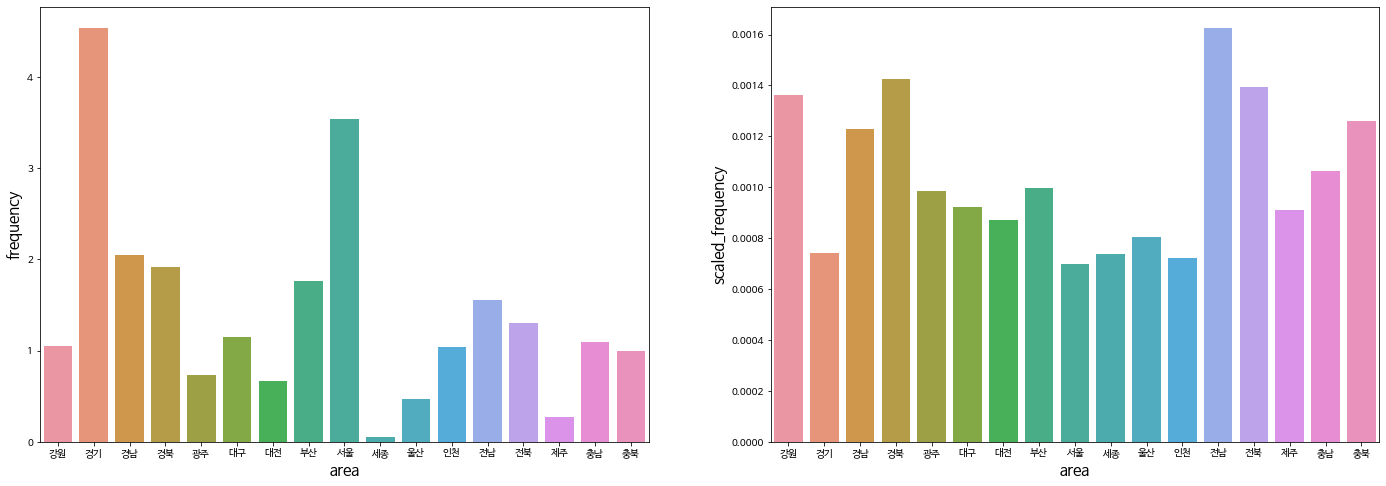

In [ ]:
df = final[final['year'] != 2016].copy()
df['scaled_frequency'] = (df['frequency'] / df['tot_person']) * 1000
df['freq'] = np.where(df['frequency'] > 0, '질환발생 O', '질환 발생 X')
f, axes = plt.subplots(1,2, figsize=(24, 8), sharex=True)
sns.barplot(data = df, x = 'area', y= 'frequency', ci=False, ax=axes[0])
sns.barplot(data = df, x = 'area', y= 'scaled_frequency', ci=False, ax=axes[1])
plt.rc('axes', labelsize=15)
plt.show()

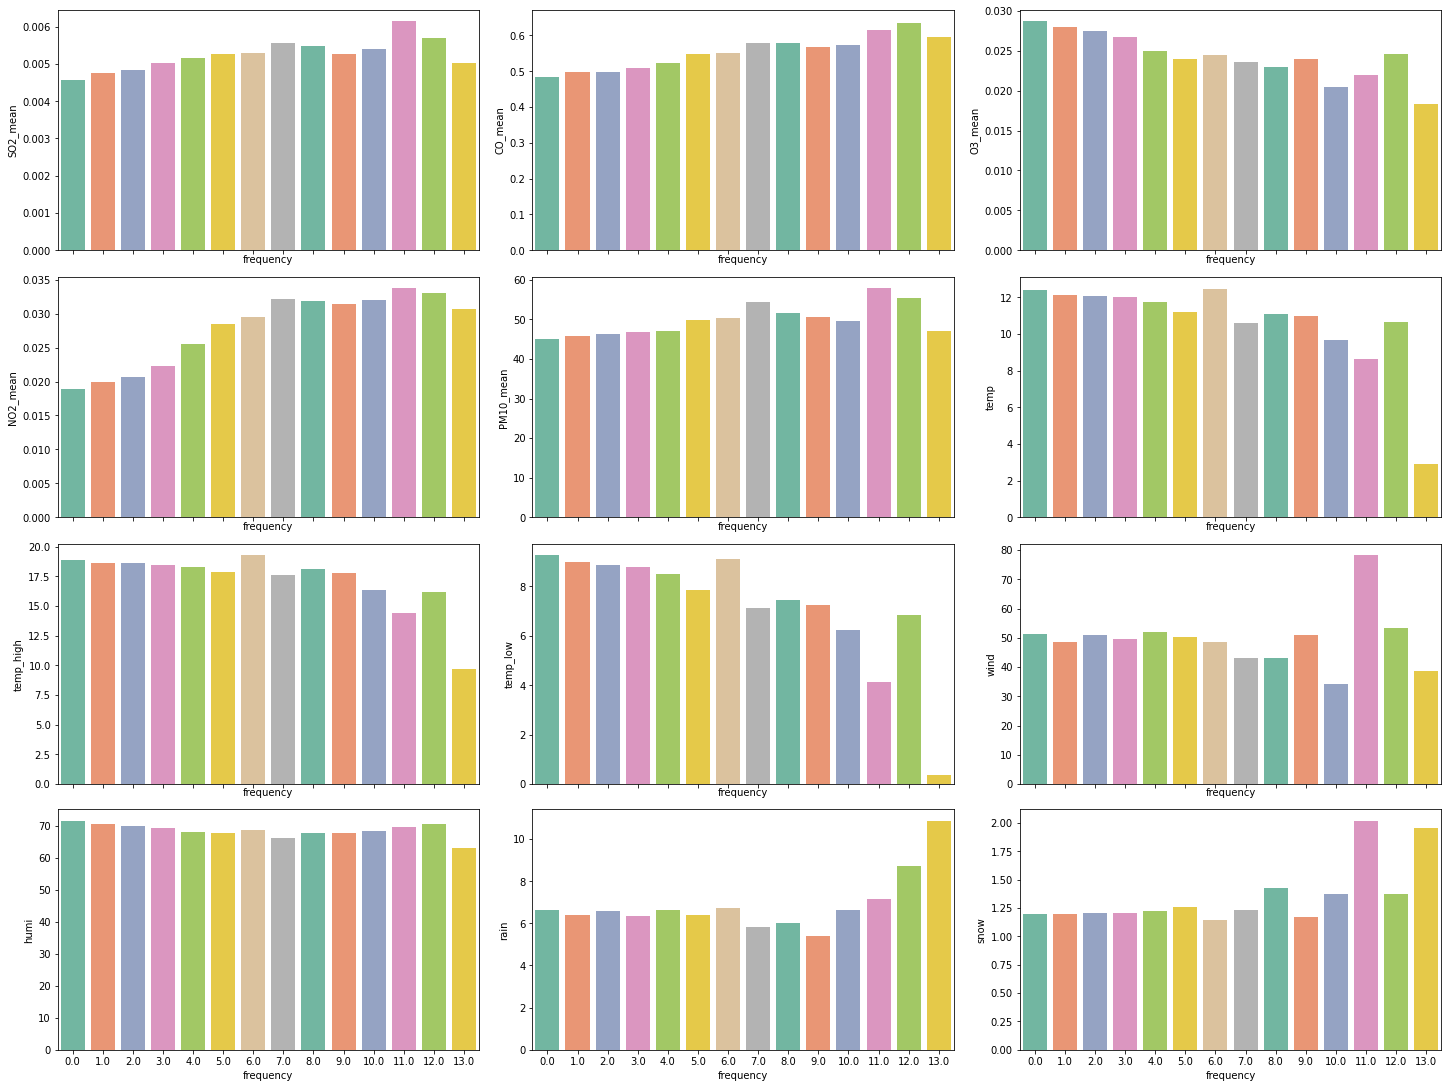

In [13]:
df = final[final['year'] != 2016].copy()
feature= ['SO2_mean', 'CO_mean', 'O3_mean', 'NO2_mean', 'PM10_mean', 'temp', 'temp_high', 'temp_low', 'wind','humi', 'rain', 'snow']
df['freq'] = np.where(df['frequency'] > 0, '질환발생 O', '질환 발생 X')
f, axes = plt.subplots(4,3, figsize=(20,15), sharex=True, constrained_layout=True)
for ax, feature in zip(axes.flatten(), feature):
    sns.barplot(data = df, x = 'frequency', y= feature, ax=ax, ci=False, palette='Set2') # , order=['질환 발생 X', '질환발생 O']
plt.rc('figure', titlesize=7)
plt.rc('axes', labelsize=15)
plt.show()

# 3. 모델링

In [6]:
final = final_back.copy()

# 새로운 변수 생성 
dates = pd.to_datetime(final.yyyymmdd, format='%Y%m%d').dt
final['year'] = dates.year
final['month'] = dates.month
final['day'] = dates.day
final['day_differ'] = [1 if i == 1 else 0 for i in final['day']]
final['month_differ'] = [1 if i in [5,6,8,9] else 0 for i in final['month']]

final['temp'] = final[['3시간기온_mean_9', '3시간기온_mean_15', '3시간기온_mean_21']].mean(axis=1)
final['humi'] = final[['습도_mean_9', '습도_mean_15', '습도_mean_21']].mean(axis=1)
final['temp_high'] = final[['일최고기온_mean_9', '일최고기온_mean_15', '일최고기온_mean_21']].max(axis=1)
final['temp_low'] = final[['일최저기온_mean_9', '일최저기온_mean_15', '일최저기온_mean_21']].min(axis=1)
final['wind'] = final[['풍속_mean_9','풍속_mean_15', '풍속_mean_21']].mean(axis=1)
final['rain'] = final[['강수량_mean_9','강수량_mean_15', '강수량_mean_21']].mean(axis=1)
final['snow'] = final[['적설_mean_9', '적설_mean_15', '적설_mean_21']].mean(axis=1)

final['A03'] = (final['A03_t1'] + final['A03_t2'] + final['A03_t3']) / 3
final['A04'] = (final['A04_t1'] + final['A04_t2'] + final['A04_t3']) / 3
final['A05'] = (final['A05_t1'] + final['A05_t2'] + final['A05_t3']) / 3
final['A06'] = (final['A06_t1'] + final['A06_t2'] + final['A06_t3']) / 3

final['weekday']= dates.weekday                                                                           # 'weekday'   : 요일 
final['risk_ratio'] = final['num_risk_age'] / final['tot_person']                                         # 'risk_ratio': 위험인구 비율 
final['day_diff'] = final['temp_high'] - final['temp_low']                                                # 'day_diff'  : 일교차

final['temp_threshold'] = np.where((final['temp_low'] < -2.5), 1, 0)                                      # 'temp_threshold' : 뇌졸중 영향 온도 threshhold
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094070

conditionlist = [    
    (final['month'].isin([3,4,5])),
    (final['month'].isin([6,7,8])),
    (final['month'].isin([9,10,11])),
    (final['month'].isin([12,1,2]))]
choicelist = [1,2,3,4]
final['season'] = np.select(conditionlist, choicelist, default='Not Specified').astype('int64')             # 'season'       : 계절 
final['diff_risk'] = np.where(final['day_diff'] >= 10, 1, 0)                                                # 'diff_risk'    : 일교차 10도 이상 
final['capital_area'] = np.where((final['area'].isin(['서울', '경기'])), 1, 0)                              # 'capital_area' : 서울, 경기 여부 
final['NO_CO']=final['NO2_mean'] * final['CO_mean']                                                         # 'NO_CO'        : 이산화질소 * 일산화탄소

# area 변수 라벨 인코딩 
cat_features = ['area']
for i in enumerate(cat_features):
    ca = i[1]
    encoder = LabelEncoder()
    encoder.fit(final[ca])
    final[ca] = encoder.transform(final[ca])

final['deriv_1'] = 1 
final.loc[final['temp'] <= -10, 'deriv_1'] = 2
final['deriv_1'] = final['deriv_1'] + (final['weekday']*10) + (final['area'] * 100)                         # 'deriv_1'        : 요일,지역 별 기온 threshhold 구분

final['deriv_2'] = 1
final.loc[final['day_diff'] >= 10, 'deriv_2'] = 2
final['deriv_2'] = final['deriv_2'] + (final['weekday']*10) + (final['area'] * 100)                         # 'deriv_2'        : 요일,지역 별 일교차 threshhold 구분

final['deriv_3'] = 1
final.loc[final['humi'] >= 50, 'deriv_3'] = 2
final['deriv_3'] = final['deriv_3'] + (final['weekday']*10) + (final['area'] * 100)                         # 'deriv_3'        : 요일,지역 별 습도 threshhold 구분

final['deriv_4'] = 1
final.loc[final['wind'] >= 18, 'deriv_4'] = 2
final['deriv_4'] = final['deriv_4'] + (final['weekday']*10) + (final['area'] * 100)                         # 'deriv_4'        : 요일,지역 별 풍속 threshhold 구분

final['deriv_5'] = final['deriv_1'] + final['deriv_2']*10 + final['deriv_3']*100 + final['deriv_4']+1000    # 'deriv_5'        : 'deriv_1' ~ 'deriv_4' 통합

final = final.drop([                    
                    '3시간기온_mean_9', '3시간기온_mean_15', '3시간기온_mean_21',
                    '습도_mean_9', '습도_mean_15', '습도_mean_21', 
                    '일최고기온_mean_9','일최고기온_mean_15', '일최고기온_mean_21', 
                    '일최저기온_mean_9','일최저기온_mean_15', '일최저기온_mean_21', 
                    '풍속_mean_9','풍속_mean_15', '풍속_mean_21', 
                    '강수량_mean_9','강수량_mean_15', '강수량_mean_21', 
                    '적설_mean_9', '적설_mean_15', '적설_mean_21',

                    'A03_t1', 'A03_t2', 'A03_t3', 
                    'A04_t1', 'A04_t2', 'A04_t3', 
                    'A05_t1', 'A05_t2', 'A05_t3', 
                    'A06_t1', 'A06_t2', 'A06_t3',
                    ], axis=1)

# train, test split 
train = final[final['year'] != 2016].drop('yyyymmdd', axis=1)
test = final[final['year'] == 2016].drop(['frequency','yyyymmdd'], axis=1)

X = train.drop(['frequency'], axis=1)
y = train['frequency']
X.columns

Index(['area', 'sex', 'tot_person', 'num_risk_age', 'SO2_mean', 'CO_mean',
       'O3_mean', 'NO2_mean', 'PM10_mean', 'year', 'month', 'day',
       'day_differ', 'month_differ', 'temp', 'humi', 'temp_high', 'temp_low',
       'wind', 'rain', 'snow', 'A03', 'A04', 'A05', 'A06', 'weekday',
       'risk_ratio', 'day_diff', 'temp_threshold', 'season', 'diff_risk',
       'capital_area', 'NO_CO', 'deriv_1', 'deriv_2', 'deriv_3', 'deriv_4',
       'deriv_5'],
      dtype='object')

### 1) CatBoostRegressor

In [12]:
# 학습함수 정의 
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])
def objective(trial: Trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 1.5, step=0.05),
        'max_bin': trial.suggest_int('max_bin', 200, 500, step=20),   
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100, step=5),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0, step=0.1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }
    model = CatBoostRegressor(**param, one_hot_max_size = 17, loss_function = 'RMSE', random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val,y_val)], early_stopping_rounds=50, verbose=False)
    rmse = RMSE(y_val, model.predict(X_val))

    return rmse

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='CatBoostRegressor-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial), n_trials=300)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-08-07 11:50:26,385] A new study created in memory with name: CatBoostRegressor-Hyperparameter-Tuning
[I 2022-08-07 11:50:38,131] Trial 0 finished with value: 1.2168364671962126 and parameters: {'max_depth': 4, 'reg_lambda': 1.5, 'max_bin': 420, 'min_data_in_leaf': 60, 'leaf_estimation_iterations': 3, 'colsample_bylevel': 0.5, 'od_type': 'Iter'}. Best is trial 0 with value: 1.2168364671962126.
[I 2022-08-07 11:50:43,471] Trial 1 finished with value: 1.2167064051087342 and parameters: {'max_depth': 4, 'reg_lambda': 1.35, 'max_bin': 200, 'min_data_in_leaf': 100, 'leaf_estimation_iterations': 13, 'colsample_bylevel': 0.5, 'od_type': 'Iter'}. Best is trial 1 with value: 1.2167064051087342.
[I 2022-08-07 11:50:49,632] Trial 2 finished with value: 1.217741915441001 and parameters: {'max_depth': 3, 'reg_lambda': 1.25, 'max_bin': 320, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 10, 'colsample_bylevel': 0.4, 'od_type': 'Iter'}. Best is trial 1 with value: 1.2167064051087342.
[I

Best trial : score 1.214590819570159, 
params {'max_depth': 5, 'reg_lambda': 1.2, 'max_bin': 240, 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 5, 'colsample_bylevel': 0.8, 'od_type': 'IncToDec'}


### 2) XGB

In [ ]:
# 학습함수 정의 
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])
def objective(trial: Trial):
    param = {
        'max_depth' : trial.suggest_int('max_depth', 2, 12),
        'subsample' : trial.suggest_float('subsample', 0.8, 1, step=0.05),
        'max_leaves' : trial.suggest_int('max_leaves', 200, 1000, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'lambda': trial.suggest_float("lambda", 0, 1, step=0.05),
        'alpha': trial.suggest_float('alpha', 0, 1, step=0.05),
        'gamma' : trial.suggest_float('gamma', 0, 1, step=0.05),
        "boosting_type": trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 200),
        "max_bin": trial.suggest_int("max_bin", 600, 1200),
    } 
    model = XGBRegressor(**param, random_seed=42, objective = 'reg:squarederror', eval_metric = 'rmse', verbose=-1, 
                         metric = 'rmse', n_jobs=-1, tree_method='gpu_hist')
    model.fit(X_train, y_train, eval_set=[(X_val,y_val)], verbose=False, early_stopping_rounds=50)
    rmse = RMSE(y_val, model.predict(X_val))

    return rmse

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='XGBRegressor-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial), n_trials=500)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-08-07 09:39:01,372] A new study created in memory with name: XGBRegressor-Hyperparameter-Tuning
[I 2022-08-07 09:39:02,872] Trial 0 finished with value: 1.199300115096052 and parameters: {'max_depth': 6, 'subsample': 1.0, 'max_leaves': 790, 'min_child_weight': 3, 'lambda': 0.15000000000000002, 'alpha': 0.15000000000000002, 'gamma': 0.05, 'boosting_type': 'gbdt', 'subsample_freq': 8, 'min_child_samples': 53, 'max_bin': 1182}. Best is trial 0 with value: 1.199300115096052.
[I 2022-08-07 09:39:05,683] Trial 1 finished with value: 1.218100633037104 and parameters: {'max_depth': 11, 'subsample': 0.8500000000000001, 'max_leaves': 340, 'min_child_weight': 1, 'lambda': 0.30000000000000004, 'alpha': 0.55, 'gamma': 0.45, 'boosting_type': 'dart', 'subsample_freq': 2, 'min_child_samples': 94, 'max_bin': 820}. Best is trial 0 with value: 1.199300115096052.
[I 2022-08-07 09:39:06,535] Trial 2 finished with value: 1.202489620034801 and parameters: {'max_depth': 7, 'subsample': 0.9500000000000

Best trial : score 1.1909040640847843, 
params {'max_depth': 4, 'subsample': 0.8, 'max_leaves': 610, 'min_child_weight': 3, 'lambda': 0.4, 'alpha': 0.9, 'gamma': 0.55, 'boosting_type': 'dart', 'subsample_freq': 3, 'min_child_samples': 175, 'max_bin': 863}


### 3) LGBM

In [8]:
# 단일 LGBM  
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])
def objective(trial: Trial):
    param = {
        'num_leaves' : trial.suggest_int('num_leaves', 2, 10),
        'max_depth' : trial.suggest_int('max_depth', 2, 50),
        'subsample' : trial.suggest_float('subsample', 0.8, 1.0, step=0.05),
        'min_child_samples' : trial.suggest_int('min_child_samples', 2, 100, 2),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 10, 100, 2),
        'max_bin' : trial.suggest_int('max_bin', 10, 100, 2),
        'reg_alpha' : trial.suggest_float('reg_alpha', 1, 1.5, step = 0.05),
        'reg_lambda' : trial.suggest_float('reg_lambda', 1, 1.5, step = 0.05)
    }
    model = LGBMRegressor(**param, random_seed=42, verbose=-1, metric = 'rmse', n_jobs=-1, n_estimators=500)
    model.fit(X_train, y_train, eval_set=[(X_val,y_val)], categorical_feature = ['area'], verbose=False, early_stopping_rounds=50)
    rmse = RMSE(y_val, model.predict(X_val))

    return rmse

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='LGBMRegressor-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial), n_trials=500)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-08-07 11:39:55,702] A new study created in memory with name: LGBMRegressor-Hyperparameter-Tuning
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['area']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
[I 2022-08-07 11:39:56,401] Trial 0 finished with value: 1.214672878592364 and parameters: {'num_leaves': 5, 'max_depth': 48, 'subsample': 0.9500000000000001, 'min_child_samples': 60, 'min_data_in_leaf': 24, 'max_bin': 24, 'reg_alpha': 1.0, 'reg_lambda': 1.45}. Best is trial 0 with value: 1.214672878592364.
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['area']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
[I 2022-08-07 11:39:57,352] Trial 1 finished with value: 1.2127372575116424 and parameters: {'num_leaves': 7, 'max_d

Best trial : score 1.2106750811877303, 
params {'num_leaves': 6, 'max_depth': 16, 'subsample': 0.8, 'min_child_samples': 46, 'min_data_in_leaf': 70, 'max_bin': 26, 'reg_alpha': 1.35, 'reg_lambda': 1.3}


### 4) 예측 및 결과

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['area']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


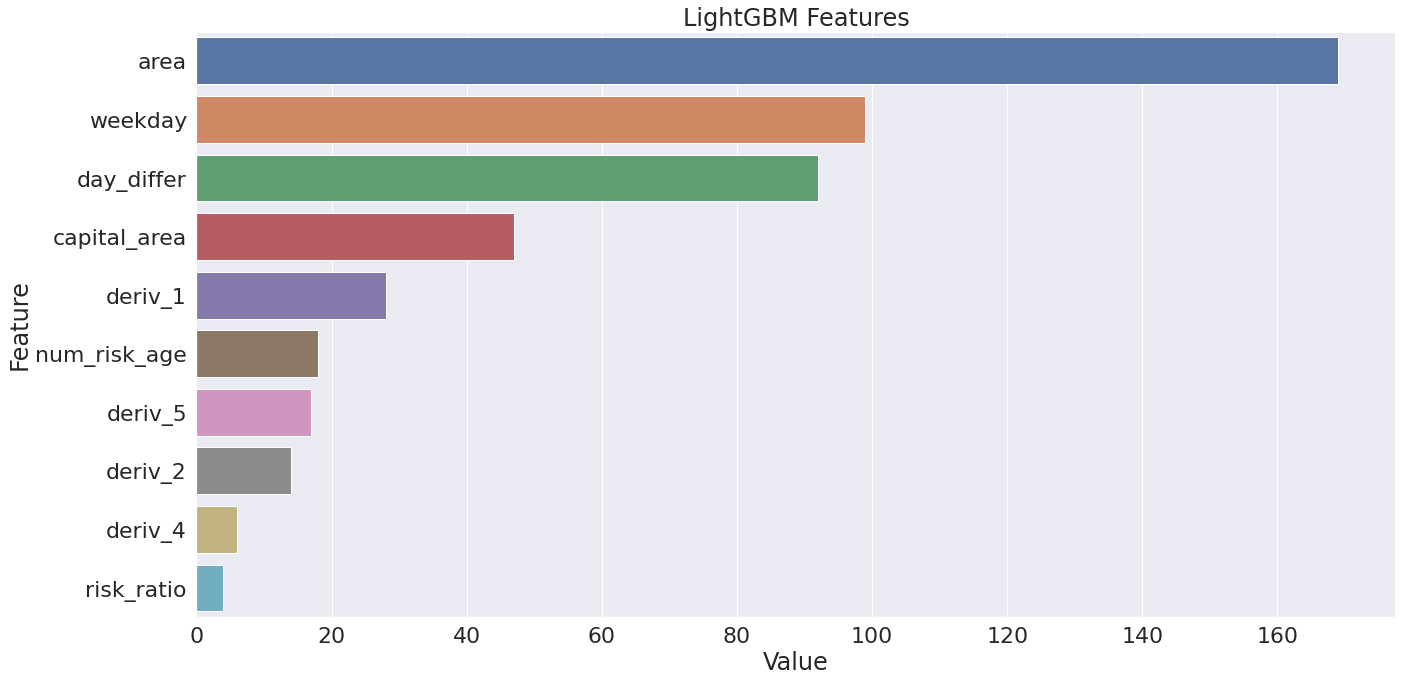

In [11]:
# feature importance
def plotImp(model, X , num = 10, fig_size = (20, 10)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()
LGBM = LGBMRegressor(**study.best_trial.params, random_state=42, verbose=-1, metric = 'rmse', n_jobs=-1, learning_rate=0.03)
LGBM.fit(X, y, categorical_feature = ['area'], verbose=False)
plotImp(LGBM, X)

In [ ]:
LGBM_pred = LGBM.predict(test)
submit['frequency'] = LGBM_pred * 1.05
submit.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/220139.csv', encoding='cp949', index=False)